#Analiza sentymenty z wykorzystaniem BERT i zbioru Amazon Reviews

Parametry:

In [11]:
datasetUrl = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz'
dataPath = './data/reviews.json.gz'

Dane karty graficznej:

In [12]:
!nvidia-smi

Thu Apr 29 17:17:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.40       Driver Version: 461.40       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:26:00.0  On |                  N/A |
| 28%   35C    P8    21W / 120W |   1207MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Zainstalowane biblioteki:

In [13]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers


Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

numpy       : 1.19.2
pandas      : 1.2.4
torch       : 1.8.1
transformers: 4.5.1



Importowane biblioteki:

In [26]:
import transformers
import pandas as pd
import gzip
import wget
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from imblearn.under_sampling import RandomUnderSampler, NearMiss

Pobieranie zbioru danych i rozpakowywanie


In [15]:
try:
    f = open(dataPath)
except IOError:
    print("File not accessible, downloading")
    wget.download(datasetUrl, out=dataPath)
finally:
    f.close()

File not accessible


Ładowanie danych:

In [16]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(dataPath)

Analiza danych:


In [17]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


In [18]:
df.shape


(551682, 9)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551682 entries, 0 to 551681
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      551682 non-null  object 
 1   asin            551682 non-null  object 
 2   reviewerName    546729 non-null  object 
 3   helpful         551682 non-null  object 
 4   reviewText      551682 non-null  object 
 5   overall         551682 non-null  float64
 6   summary         551682 non-null  object 
 7   unixReviewTime  551682 non-null  int64  
 8   reviewTime      551682 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 42.1+ MB


Text(0.5, 0, 'review score')

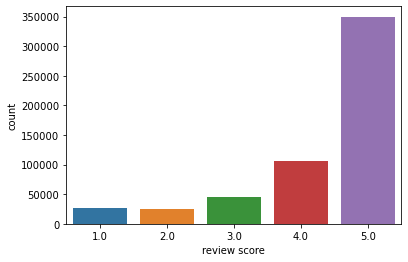

In [43]:
sns.countplot(x='overall', data=df)
plt.xlabel('review score')

Jak widać zbiór jest mocno niezbalansowany, więc zostanie zastosowany random undersampling

Text(0.5, 0, 'review score')

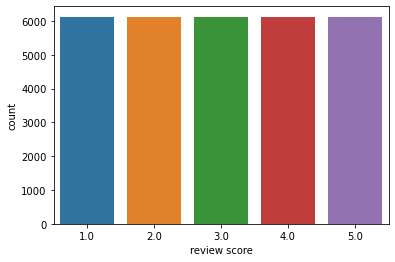

In [44]:
# Separating the independent variables from dependent variables
X = df[['reviewText']]
y = df[['overall']]

#Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.25)

undersample = RandomUnderSampler(sampling_strategy='not minority')
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

sns.countplot(x='overall',data=y_train_under)
plt.xlabel('review score')
